<a href="https://colab.research.google.com/github/MScharnberg/IntSys19/blob/master/IntSys19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IntSys19

Intelligent Systems

---

[@mats.scharnberg](mailto:mats.scharnberg@study.hs-duesseldorf.de)

[@christoph.schneider](mailto:christoph.schneider@study.hs-duesseldorf.de)

[@tobias.vossen](mailto:tobias.vossen@study.hs-duesseldorf.de)

## Contents

* Setup
* Data
* Model
* Deployment
* Exit strategy

## Setup

### Magic

In [0]:
%matplotlib inline
%load_ext tensorboard 

### Libraries

In [0]:
import datetime
import os
from timeit import default_timer as timer

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from tensorboard import version
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

print('Keras version:', keras.__version__)
print('NumPy version:', np.__version__)
print('TensorBoard version:', version.VERSION)
print('TensorFlow version:', tf.__version__)
print('TensorFlow Datasets version:', tfds.__version__)

Keras version: 2.3.0-tf
NumPy version: 1.18.4
TensorBoard version: 2.2.2
TensorFlow version: 2.2.0
TensorFlow Datasets version: 2.1.0


### Utils

In [0]:
def check_env():
  """Check hardware accelerator for training"""

  if not tf.test.gpu_device_name():
    print('WARNING: Running on CPU. Training may take a while...\n')
  else:
    print('WARNING: Running on GPU. Ressources may be temporarly blocked...\n')

In [0]:
def get_logs():
  """Setup logging"""

  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y-%m-%d'))
  print('INFO: Logs will be written to', logdir, '\n')
  return tf.summary.create_file_writer(logdir)

In [0]:
def get_metrics():
  """Setup metrics"""

  metrics = {
    'loss/generator' : keras.metrics.Mean(),
    'loss/discriminator' : keras.metrics.Mean(),
    'loss/realVSfake' : keras.metrics.Mean(),
    'eval/kld' : keras.metrics.KLDivergence(),
    'eval/mse' : keras.metrics.MeanSquaredError()
  }
  print('INFO:', len(metrics), 'metrics to measure including...')
  for key in metrics.keys():
    print(key)
  return metrics

## Data

*   Choose dataset
*   Load dataset
*   Explore dataset
*   Preprocess dataset
*   Visualize dataset


In [0]:
# Global data parameter
_BS = 64 #@param {type:"slider", min:64, max:256, step:64}
_DIM = 28 #@param ["28"] {type:"raw"}
_SHAPE = (_DIM, _DIM, 1) # Image shape

# Local data parameter
ds = 'mnist' # String identifier for dataset

In [0]:
_DATA = {
    'Batch size' : _BS,
    'Image dimension' : _DIM,
    'Image shape' : _SHAPE
}

### Choose dataset

In [0]:
# To do

### Load dataset

In [0]:
def load_dataset(ds):
  """Load dataset by means of TFDS (TensorFlow Datasets)
  
  Args:
    dataset: str
  
  Returns:
    train: tf.data.Dataset
    test: tf.data.Dataset
  """

  (train, test) = tfds.load(ds,
                            split=['train', 'test'],
                            shuffle_files=True,
                            as_supervised=True)
  
  return train, test

In [11]:
train, test = load_dataset(ds)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


### Explore dataset

In [0]:
# To do

### Preprocess dataset

In [0]:
def normalize(image, label):
  """Normalize dataset 
  
  Normalize:
    Cast -> Normalize

  Args:
    image: tf.Tensor as Integer
    label: tf.Tensor as Integer
  
  Returns:
    image: tf.Tensor as Float
    label: tf.Tensor as Integer
  """

  image = tf.cast(image, tf.float32) # 0...255
  image = (image - 127.5) / 127.5 # -1...1
  return image, label

In [0]:
def preprocess(ds, shuffle=True, batch=True):
  """Preprocess dataset

  Preprocess: 
    Normalize -> Shuffle -> Batch
  
  Args:
    ds: tf.data.Dataset
    shuffle: boolean
    batch: boolean
  
  Returns:
    ds: tf.data.Dataset
  """

  ds = ds.map(normalize)
  if shuffle: ds = ds.shuffle(shuffle_size)
  if batch: ds = ds.batch(_BS, drop_remainder=True)
  return ds

In [0]:
train = preprocess(train, shuffle=False)
test = preprocess(test, shuffle=False)

### Visualize dataset

In [0]:
def visualize(ds):
  """Visualize dataset
  
  Args:
    ds: tf.data.Dataset
  
  Returns:
    fig: plt.figure
  """

  ds = ds.unbatch()
  fig = plt.figure(figsize=(16, 16))
  i = 0
  for example in ds.take(36):
    fig.add_subplot(6, 6, i+1)
    plt.imshow(tf.squeeze(example[0], -1), cmap='gray')
    plt.axis('off')
    i = i+1
  plt.show()
  return fig

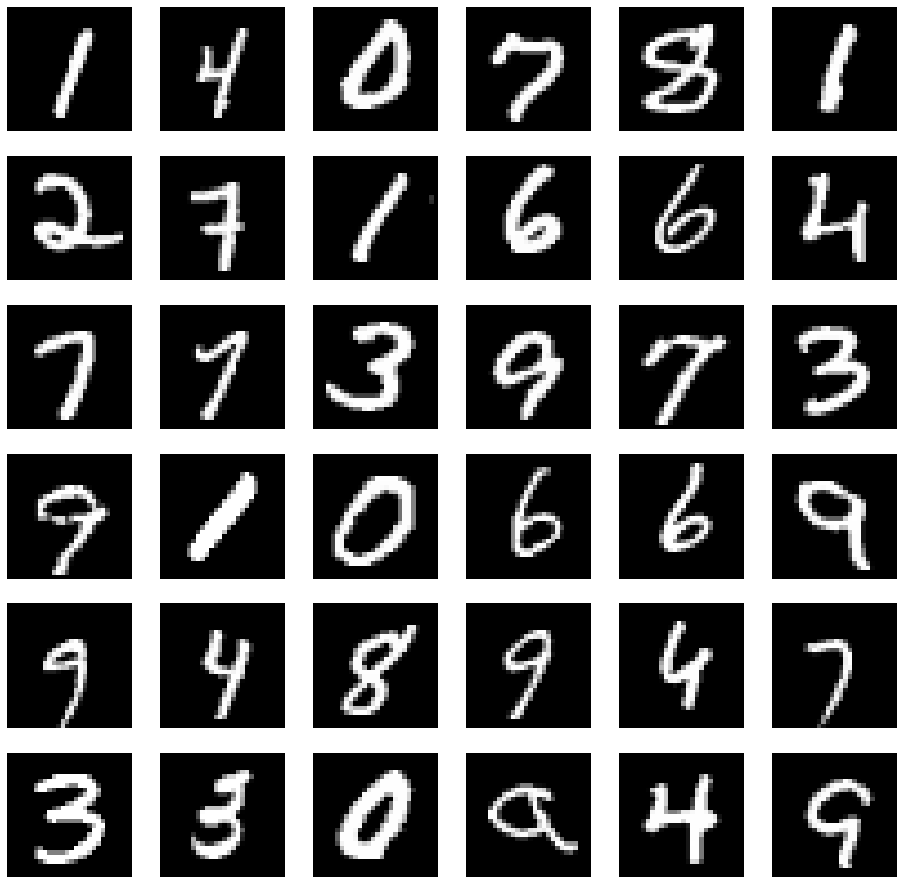

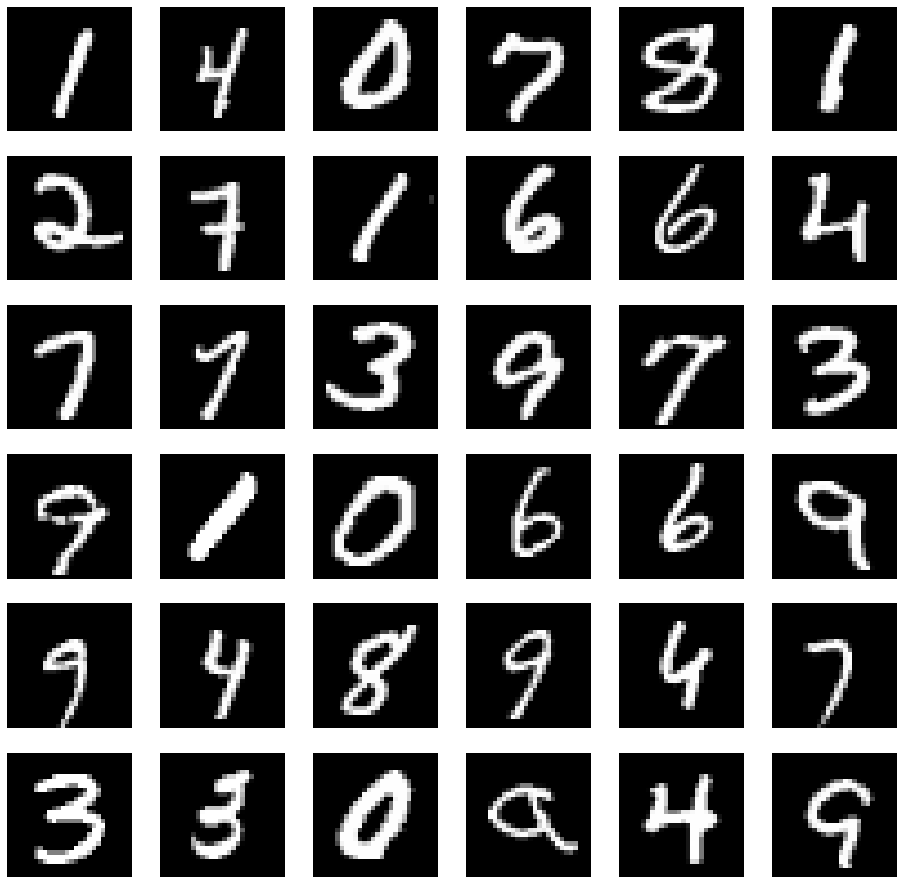

In [17]:
visualize(train)

## Model

*   Choose model
*   Compile model
*   Train model
*   Evaluate model

In [0]:
# Global model parameter
_EPOCHS = 10 #@param {type:"slider", min:10, max:100, step:10}
_LR = 1e-3 # Learning rate

In [0]:
_MODEL = {
    'Epochs' : _EPOCHS,
    'Learning rate' : _LR
}

### Choose model

#### Generator

In [0]:
def get_generator():
  """ Generator as faking model
  
  Architecture: Encoder-Decoder
    Input -> Dense -> Reshape -> Convolution -> Normalization -> Activation ->
    Inverse Convolution
              
  Returns:
    keras.Model
  """

  first = keras.Input(shape=(196, ))
  layer = keras.layers.Dense(196)(first)
  layer = keras.layers.Reshape((7, 7, 4))(layer)

  for i in range(2):
    layer = keras.layers.Conv2DTranspose(8*2**i, (3, 3), strides=2, padding='same')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.LeakyReLU()(layer)
  
  last = keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', activation='tanh')(layer)

  return keras.Model(inputs=first, outputs=last, name='Generator')

In [21]:
generator = get_generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 196)]             0         
_________________________________________________________________
dense (Dense)                (None, 196)               38612     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         296       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        11

#### Discriminator

In [0]:
def get_discriminator():
  """ Discriminator as expertise model
  
  Architecture: Encoder
    Input -> Convolution -> Normalization -> Activation -> Flatten -> Dense
              
  Returns:
    keras.Model
  """

  first = keras.Input(shape=_SHAPE)
  layer = first

  for i in reversed(range(2)):
    layer = keras.layers.Conv2D(8*2**i, (3, 3), strides=2, padding='same')(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.LeakyReLU()(layer)

  layer = keras.layers.Flatten()(layer)
  layer = keras.layers.Dense(98)(layer)
  last = keras.layers.Dense(1)(layer)

  return keras.Model(inputs=first, outputs=last, name='Discriminator')

In [23]:
discriminator = get_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 8)           32        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 8)         

### Compile model

In [0]:
def objective():
  """Binary crossentropy objective function
  
  Returns:
    keras.losses 
  """

  return keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def generator_loss(fake_output):
  """Generator loss
  
  Returns:
    generator_loss: tf.Tensor as Float
  """

  generator_loss = loss_fn(tf.ones_like(fake_output), fake_output)
  return generator_loss

In [0]:
def discriminator_loss(real_output, fake_output):
  """Discriminator loss
  
  Returns:
    discriminator_loss: tf.Tensor as Float
    loss_quotient: tf.Tensor as Float
  """

  real_loss = loss_fn(tf.ones_like(real_output), real_output)
  fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
  discriminator_loss = real_loss + fake_loss
  loss_quotient = real_loss / fake_loss
  return discriminator_loss, loss_quotient

In [0]:
def optimizer(learning_rate):
  """Adam optimizer with exponential decay, as learning rate decreases over time
  
  Args:
    learning_rate: tf.float32
  
  Returns:
    keras.optimizer
  """
  
  schedule = keras.optimizers.schedules.ExponentialDecay(
      learning_rate,
      decay_steps=10,
      decay_rate=0.96)

  return tf.keras.optimizers.Adam(schedule)

In [0]:
loss_fn = objective()

### Train model

In [0]:
def train_step(images, noise, metrics):
  """Train step
  
  Step:
    Generate fake images -> Update evaluation metrics -> Let Discriminator
    classify -> Compute losses -> Update loss metrics -> Compute gradients ->
    Apply gradients

  Args:
    images: tf.Tensor as Float
      Real data distribution
    noise: tf.Tensor as Float
      Imaginary data distribution
  """

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    generated_images = generator(noise, training=True)

    metrics['eval/kld'].update_state(images, generated_images)
    metrics['eval/mse'].update_state(images, generated_images)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    metrics['loss/generator'].update_state(gen_loss)
    disc_loss, realVSfake = discriminator_loss(real_output, fake_output)
    metrics['loss/discriminator'].update_state(disc_loss)
    metrics['loss/realVSfake'].update_state(realVSfake)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  optimizer(learning_rate=_LR).apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  optimizer(learning_rate=_LR).apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train_model(dataset):
  """Train model
  
  Train:
    Iterate over epochs -> Iterate over batches -> Train step per batch ->
    Save (and reset) metrics

  Args:
    images: tf.data.Dataset
  """
  
  check_env()
  logging = get_logs()
  metrics = get_metrics()
  start = timer()

  print('\nEpoch\tGEN\tDIS\tRvsF\tKLD\tMSE\tElapsed\tETA')

  for epoch in range(1, _EPOCHS+1): # Iterate over epochs

    epoch_start = timer()
    output = [epoch, _EPOCHS] 

    for batch in dataset: # Iterate over batches
      image_batch = batch[0]
      noise = tf.random.normal([_BS, 196])
      train_step(image_batch, noise, metrics)

    with logging.as_default(): # Save (and reset) metrics
      tf.summary.histogram('input/noise', noise[-1], step=epoch)
      tf.summary.image('output/digit', generator(tf.expand_dims(noise[-1], 0), training=False), step=epoch)
      tf.summary.scalar('optimizer/lr', optimizer(learning_rate=_LR).lr(epoch), step=epoch)

      for key, metric in metrics.items(): # Loss metrics
        tf.summary.scalar(key, metric.result(), step=epoch)
        output.append(metric.result().numpy())
        metric.reset_states()

    output.append((timer()-start)/60)
    output.append(((timer()-epoch_start) * (_EPOCHS-epoch))/60)
    print('%i/%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.1f m\t%.1f m' % tuple(output))

In [31]:
train_model(train)


INFO: Logs will be written to logs/2020-06-08 

INFO: 5 metrics to measure including...
loss/generator
loss/discriminator
loss/realVSfake
eval/kld
eval/mse

Epoch	GEN	DIS	RvsF	KLD	MSE	Elapsed	ETA
1/10	1.967	1.432	2.012	1.130	0.551	88.4 s	13.3 m
2/10	0.832	1.342	1.313	1.082	0.547	171.3 s	11.1 m
3/10	0.821	1.328	1.244	1.076	0.546	254.7 s	9.7 m
4/10	0.807	1.335	1.196	1.068	0.534	337.6 s	8.3 m
5/10	0.827	1.317	1.198	1.063	0.530	420.4 s	6.9 m
6/10	0.829	1.312	1.187	1.058	0.535	503.6 s	5.5 m
7/10	0.880	1.285	1.285	1.058	0.533	587.3 s	4.2 m
8/10	0.911	1.256	1.324	1.058	0.535	670.3 s	2.8 m
9/10	0.928	1.249	1.344	1.052	0.536	753.4 s	1.4 m
10/10	0.950	1.244	1.366	1.058	0.534	837.1 s	0.0 m


### Evaluate model

In [0]:
board = False #@param ["False", "True"] {type:"raw"}
if board: # Visualize metrics in TensorBoard
  %tensorboard --logdir logs/

## Deployment


*   Use model
*   Export model
*   Export metadata

In [0]:
# Global deployment parameter

In [0]:
_DEPLOYMENT = {
}

### Use model

In [0]:
def predict():
  """ Generate digits

  Predict:
    Prediction -> Visualization 

  Returns:
    plt.fig
  """

  fig = plt.figure(figsize=(16, 16))

  for i in range(36): # Generate 36 digits
    fig.add_subplot(6, 6, i+1)
  
    # Prediction
    noise = tf.random.normal([1, 196]) # (BS, 196)
    prediction = generator(noise, training=False) # (BS, 28, 28, 1)

    # Visualization
    prediction = tf.squeeze(prediction, 0) # (28, 28, 1)
    plt.imshow(tf.squeeze(prediction, -1), cmap='gray') # (28, 28)
    plt.axis('off')

  plt.show()
  return fig

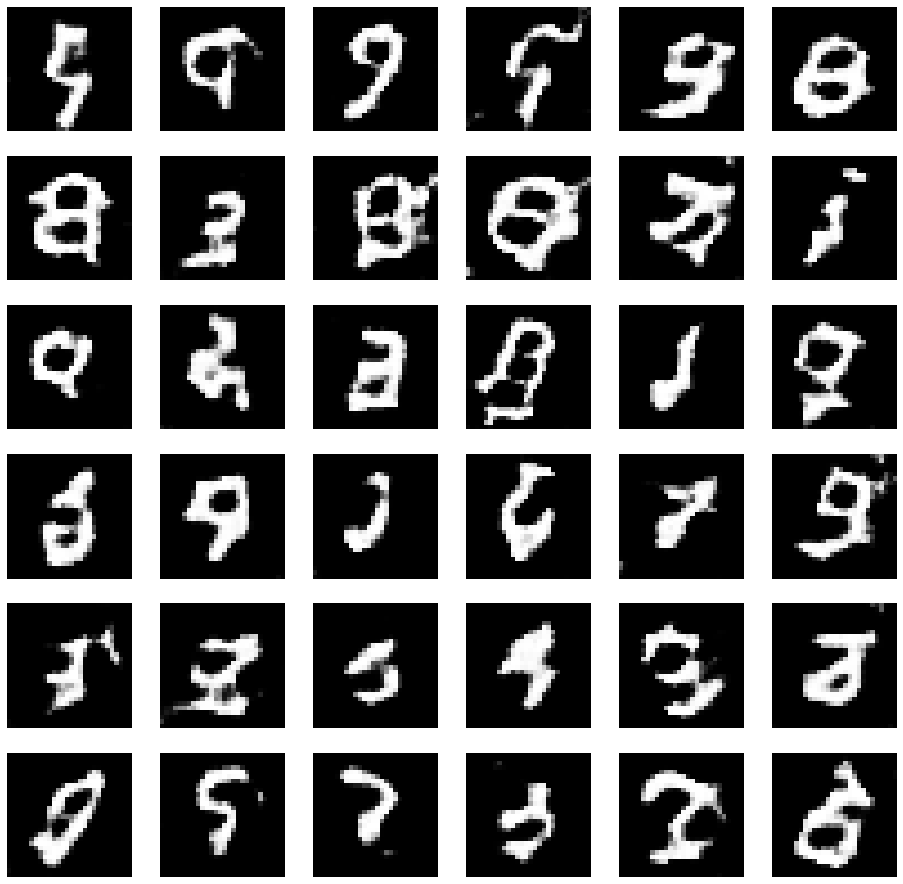

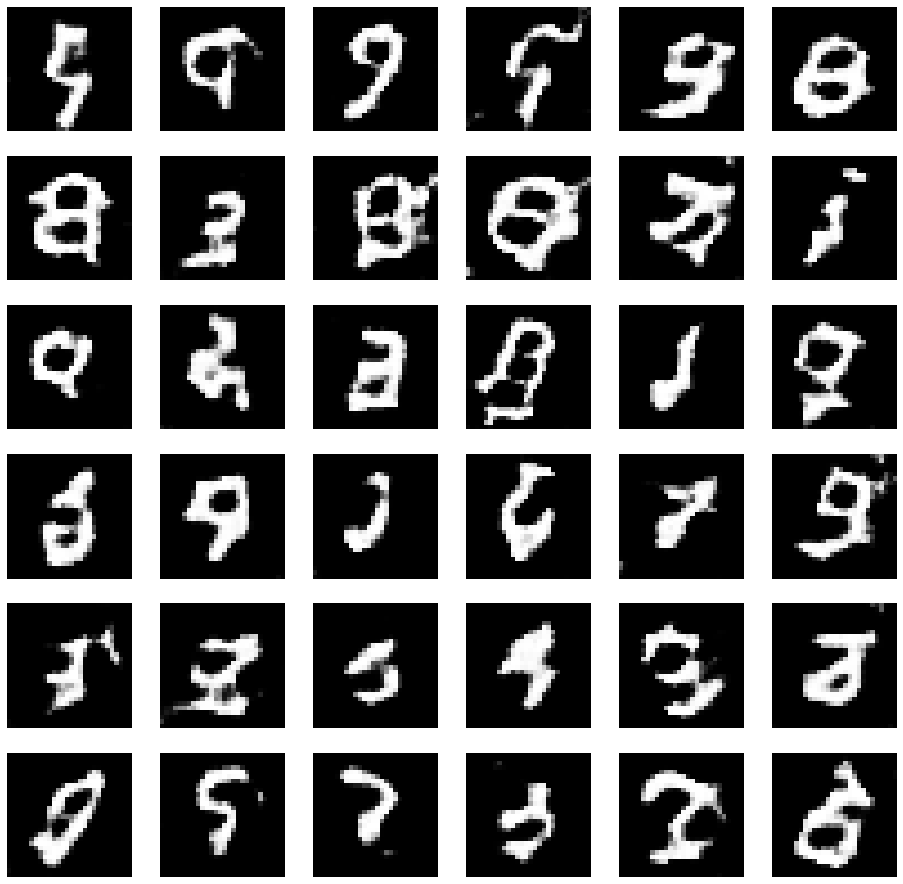

In [36]:
predict()

### Export model

In [0]:
export = False #@param ["False", "True"] {type:"raw"}
if export: # Export model
  model.save('./generator.h5')

### Export metadata

In [0]:
def print_parameter(parameter, domain):
  print(domain, 'domain:')
  for key, value in parameter.items(): 
    print(key, '=', value)
  print('')

In [42]:
print_parameter(_DATA, 'Data')
print_parameter(_MODEL, 'Model')
print_parameter(_DEPLOYMENT, 'Deployment')

Data domain:
Batch size = 64
Image dimension = 28
Image shape = (28, 28, 1)

Model domain:
Epochs = 10
Learning rate = 0.001

Deployment domain:



In [0]:
upload = False #@param ["False", "True"] {type:"raw"}
if upload:
  !tensorboard dev upload --logdir logs \
      --name "IntSys19" \
      --description "Intelligent Systems"